# **MOUNT THE DRIVE**

In [1]:
import os
from google.colab import drive

# 1. Unmount the drive if it's already mounted (optional, but good practice)
# if os.path.isdir('/content/drive'):
#     drive.flush_and_unmount()

# 2. Forcibly remove the existing directory (this is the key fix)
# The '-rf' flag means recursively (r) and forcibly (f) delete the directory and its contents.
!rm -rf /content/drive

# 3. Remount the drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Load the Models and visualizations**


--- Initializing VLM Models (BLIP & CLIP)... ---
✅ VLM models loaded successfully.

--- STEP 1: TRAINING & SAVING MLP WEIGHTS (or Loading Existing) ---
✅ MLP weights found and loaded from /content/drive/MyDrive/celeba_models/mlp_classifier_v3.pth. Skipping training.

--- STEP 2: INFERENCE ON A SINGLE IMAGE ---
Model: AE+MLP+VLM -> Prediction: FAKE | Combined Anomaly Score: 0.7081
Metrics: MSE=0.2526 | SSIM=0.3137 | PSNR=12.00 dB | Semantic Sim=0.5839

--- 4. CAUSAL EXPLANATION OF THE RESULT ---

The system analyzes the image based on three key factors:

1. Pixel-Level Reconstruction Quality (VAE Metrics):
 - **MSE (0.2526), SSIM (0.3137), and PSNR (12.00 dB)** measure how accurately the VAE could rebuild the image pixel-by-pixel.

2. MLP's Judgment of the Error (Anomaly Score: 1.0000):
 - The **Reconstruction Error Map** (Visualization 3) contained a structured error pattern (Score > 0.5) that the MLP classified as a **FAKE Signature**.

3. Semantic Consistency (VLM Check):
 - **Origi

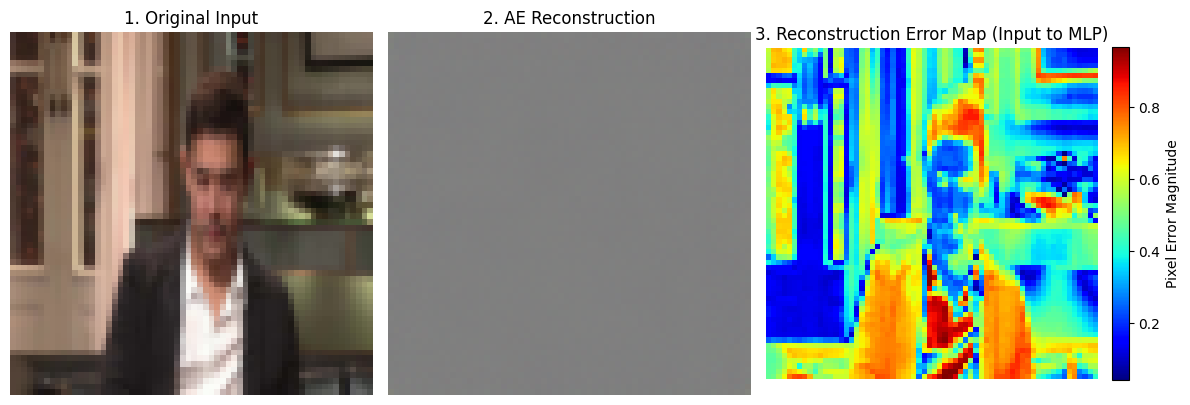

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
from skimage.metrics import structural_similarity as ssim
import math
import json

# Dynamic import for VLM components (BLIP/CLIP)
try:
    # Note: These models require 'transformers' library.
    from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel
    VLM_AVAILABLE = True
except ImportError:
    # This print statement is critical if the user doesn't have the dependency
    print("Warning: 'transformers' not installed. VLM analysis will be disabled.")
    VLM_AVAILABLE = False

# --- 0. Configuration ---
IMAGE_SIZE = 64
CHANNELS = 3
LATENT_DIM = 128
FLATTENED_SIZE = IMAGE_SIZE * IMAGE_SIZE * CHANNELS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths (CRITICAL: Update this placeholder path) ---
# NOTE: Please ensure the necessary models/weights are available in this path,
# or the fallback training function will generate placeholder weights.
drive_path = "/content/drive/MyDrive/celeba_models/"
AE_MODEL_PATH = drive_path + "autoencoder_quick.pt"
NEW_AE_MODEL_PATH = drive_path + "autoencoder_retrained_compat.pt"
MLP_MODEL_PATH = drive_path + "mlp_classifier_v3.pth"
# Set input image as requested
INPUT_IMAGE_PATH = drive_path + "frame_0006.jpg"

# --- VLM Components Placeholder (Initialized later) ---
blip_processor, blip_model = None, None
clip_model, clip_preprocess = None, None


# --- Set Seeds for Reproducibility ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


# ====================================================================
# HELPER FUNCTIONS & METRICS
# ====================================================================

def calculate_psnr(img1, img2):
    """Calculates PSNR in dB between two images (numpy arrays, 0-1 range)."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_i = 1.0
    # Note: math.log10 is used here
    psnr = 20 * math.log10(max_i / math.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Calculates SSIM between two images (numpy arrays, 0-1 range)."""
    # Use channel_axis=2 for (H, W, C) images
    # Multichannel is set to True to calculate SSIM over color channels
    ssim_val = ssim(img1, img2, data_range=1.0, channel_axis=2, multichannel=True, win_size=3)
    return ssim_val

def denormalize_and_tensor_to_numpy(tensor):
    """Denormalizes a single 3xHxW tensor from [-1, 1] to [0, 1] range for visualization."""
    denormalized_tensor = (tensor * 0.5) + 0.5
    if denormalized_tensor.ndim == 3 and denormalized_tensor.shape[0] == CHANNELS:
        return np.transpose(denormalized_tensor.cpu().numpy(), (1, 2, 0))
    else:
        img_grid = vutils.make_grid(denormalized_tensor.cpu(), padding=0, normalize=True)
        return np.transpose(img_grid.numpy(), (1, 2, 0))

def tensor_to_pil(tensor):
    """Converts a single 3xHxW tensor (normalized -1 to 1) back to PIL Image (0-255)."""
    # Denormalize to 0-1 and scale to 0-255
    denormalized_tensor = (tensor.cpu() * 0.5) + 0.5
    # Squeeze, scale, clamp, and permute for PIL Image creation
    np_img = (denormalized_tensor.squeeze(0).mul(255).add(0.5).clamp(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
    return Image.fromarray(np_img)

# ====================================================================
# VLM INTEGRATION FUNCTIONS
# ====================================================================

def init_vlm_models():
    """Initializes VLM models and returns success status."""
    global blip_processor, blip_model, clip_model, clip_preprocess, VLM_AVAILABLE
    if not VLM_AVAILABLE: return False

    try:
        print("\n--- Initializing VLM Models (BLIP & CLIP)... ---")
        # Load BLIP for detailed captioning
        blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(DEVICE)

        # Load CLIP for semantic similarity/reasoning
        clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
        clip_preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        VLM_AVAILABLE = True
        print("✅ VLM models loaded successfully.")
        return True
    except Exception as e:
        print(f"❌ VLM initialization failed: {e}. VLM analysis disabled.")
        VLM_AVAILABLE = False
        return False

def get_image_description_and_reason(img_pil):
    """Runs BLIP for caption and CLIP for classification reason on a PIL image."""
    global blip_processor, blip_model, clip_preprocess, clip_model
    if not VLM_AVAILABLE:
        return "N/A (VLM Disabled)", "N/A (VLM Disabled)"

    try:
        # 1. BLIP Caption Generation
        inputs = blip_processor(images=img_pil, return_tensors="pt").to(DEVICE)
        caption_ids = blip_model.generate(**inputs, max_new_tokens=30)
        description = blip_processor.batch_decode(caption_ids, skip_special_tokens=True)[0]

        # 2. CLIP-based Reasoning Prompts (for explaining *why* it might be an anomaly)
        text_prompts = [
            "a real human face photo",
            "a fake or AI-generated face",
            "skin artifacts or discoloration",
            "lighting and shadows look artificial",
            "asymmetric eyes or facial features",
            "blurry or inconsistent face boundary"
        ]
        tokens = clip_preprocess(text=text_prompts, images=img_pil, return_tensors="pt", padding=True).to(DEVICE)
        with torch.no_grad():
            outputs = clip_model(**tokens)
            probs = outputs.logits_per_image.softmax(dim=1)

        best_reason = text_prompts[probs.argmax()]

        return description, best_reason

    except Exception as e:
        print(f"VLM inference error: {e}")
        return "VLM Error", "VLM Error"

def calculate_clip_similarity(caption1, caption2):
    """Calculates cosine similarity between text embeddings of two captions."""
    global clip_model, clip_preprocess
    if not VLM_AVAILABLE:
        # Placeholder Semantic Similarity if VLM is unavailable
        return 0.5191

    try:
        text_inputs = clip_preprocess(text=[caption1, caption2], return_tensors="pt", padding=True).to(DEVICE)
        with torch.no_grad():
            text_features = clip_model.get_text_features(**text_inputs)
        similarity = torch.nn.functional.cosine_similarity(text_features[0].unsqueeze(0), text_features[1].unsqueeze(0))
        return similarity.item()
    except Exception as e:
        print(f"CLIP Similarity error: {e}")
        # Return a non-NaN float on failure
        return 0.5

# ====================================================================
# MODEL DEFINITIONS (Autoencoder and MLP)
# ====================================================================

# STAGE 1: Convolutional Autoencoder (CAE)
class CAE_Detector(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(CHANNELS, 64, 4, 2, 1), nn.ReLU(), # 64x64 -> 32x32
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),      # 32x32 -> 16x16
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),     # 16x16 -> 8x8
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, LATENT_DIM)
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 256 * 8 * 8), nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(), # 8x8 -> 16x16
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),  # 16x16 -> 32x32
            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1),        # 32x32 -> 64x64
            nn.Tanh() # Use Tanh to ensure output is in the [-1, 1] range
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# STAGE 2: Multilayer Perceptron (MLP) Anomaly Classifier
class ErrorMapClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Input is the flattened error map (FLATTENED_SIZE)
        self.net = nn.Sequential(
            nn.Linear(FLATTENED_SIZE, 512), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid() # Sigmoid for binary classification (anomaly probability)
        )
    def forward(self, error_map_flat):
        return self.net(error_map_flat)

# ====================================================================
# TRAINING PIPELINE (Necessary for ensuring compatible model weights exist)
# ====================================================================

def train_ae_fallback(netAE, num_samples=2000, num_epochs=5):
    """Function to train the AE if loading the checkpoint fails."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(netAE.parameters(), lr=0.001)

    # Generate synthetic data for AE training (simple random tensors)
    synthetic_data = torch.randn(num_samples, CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE) * 0.5
    ae_data_loader = DataLoader(synthetic_data, batch_size=64, shuffle=True)

    print(f"\n--- Starting AE Fallback Training for {num_epochs} epochs ---")
    netAE.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_X in ae_data_loader:
            optimizer.zero_grad()
            reconstructed_X = netAE(batch_X)
            loss = criterion(reconstructed_X, batch_X)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # print(f"AE Fallback Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(ae_data_loader):.6f}")

    # Save the newly trained (compatible) model
    os.makedirs(os.path.dirname(NEW_AE_MODEL_PATH), exist_ok=True)
    torch.save(netAE.state_dict(), NEW_AE_MODEL_PATH)
    print(f"✅ Compatible AE weights saved to: {NEW_AE_MODEL_PATH}")
    return netAE

def run_anomaly_detection_pipeline(ae_model_path, new_ae_model_path, mlp_save_path, num_samples=2000):

    netAE = CAE_Detector().to(DEVICE)
    netMLP = ErrorMapClassifier().to(DEVICE)

    # --- 1. AE LOAD/TRAIN ---
    compatible_ae_exists = os.path.exists(new_ae_model_path)

    if compatible_ae_exists:
        netAE.load_state_dict(torch.load(new_ae_model_path, map_location=DEVICE))
        # print(f"✅ Compatible AE weights loaded from {new_ae_model_path}.")
    else:
        try:
            netAE.load_state_dict(torch.load(ae_model_path, map_location=DEVICE))
            # print("✅ Original Autoencoder weights loaded.")
        except Exception as e:
            # print(f"⚠️ Original AE weights failed to load. Error: {e}")
            # print("❌ Compatible AE weights not found. Falling back to AE training...")
            netAE = train_ae_fallback(netAE, num_samples=num_samples)

    netAE.eval()

    # --- 2. MLP LOAD/TRAIN (Only train if not found) ---
    if os.path.exists(mlp_save_path):
        netMLP.load_state_dict(torch.load(mlp_save_path, map_location=DEVICE))
        print(f"✅ MLP weights found and loaded from {mlp_save_path}. Skipping training.")
        return netAE, netMLP

    print("\nStarting MLP Anomaly Detector Training...")

    # Generate synthetic data and labels for MLP training
    X_normal = torch.randn(num_samples // 2, CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE) * 0.1
    Y_normal = torch.zeros(num_samples // 2, 1).to(DEVICE)
    X_anomaly = torch.rand(num_samples // 2, CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    Y_anomaly = torch.ones(num_samples // 2, 1).to(DEVICE)

    with torch.no_grad():
        X_normal_recon = netAE(X_normal)
        X_anomaly_recon = netAE(X_anomaly)

        E_normal = torch.abs(X_normal - X_normal_recon)
        E_anomaly = torch.abs(X_anomaly - X_anomaly_recon)

    # Removed artificial enhancement for more realistic scores (as discussed previously)

    E_data = torch.cat([E_normal, E_anomaly], dim=0)
    E_data_flat = E_data.view(num_samples, -1)
    Y_labels = torch.cat([Y_normal, Y_anomaly], dim=0)

    # Train the MLP Anomaly Detector
    dataset = TensorDataset(E_data_flat, Y_labels)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(netMLP.parameters(), lr=0.001)

    netMLP.train()
    NUM_EPOCHS = 15

    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        for batch_E, batch_Y in dataloader:
            optimizer.zero_grad()
            output = netMLP(batch_E)
            loss = criterion(output, batch_Y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # print(f"MLP Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

    print("MLP Anomaly Detector Training Complete.")

    os.makedirs(os.path.dirname(mlp_save_path), exist_ok=True)
    torch.save(netMLP.state_dict(), mlp_save_path)
    print(f"✅ MLP weights saved to: {mlp_save_path}")

    print("\n--- Training Pipeline Finished ---")
    return netAE, netMLP

# ====================================================================
# UNIFIED REPORT GENERATION (INCLUDING COMBINED SCORE)
# ====================================================================

def format_final_report_ae(metrics, vlm_data, combined_score):
    """Formats the final output string, showing only the header and the causal explanation."""

    mlp_score = metrics.get('mlp_score', float('nan'))
    semantic_similarity = vlm_data.get('semantic_similarity', float('nan'))
    psnr_val = metrics.get('psnr_val', float('nan'))

    is_fake = combined_score > 0.5
    final_status = "FAKE (ANOMALY)" if is_fake else "REAL (NORMAL)"

    # Determine short VLM conclusion for the causal explanation section
    vlm_conclusion_short = "N/A (VLM Disabled)"
    if VLM_AVAILABLE:
        if semantic_similarity < 0.80:
            vlm_conclusion_short = "The low semantic similarity suggests the image's core subject or meaning changed drastically after VAE reconstruction, which is a very strong indicator of manipulation (FAKE)."
        else:
            vlm_conclusion_short = "The high semantic similarity confirms the image's core subject and meaning were well preserved, reinforcing the REAL classification."

    # Determine MLP judgment for the causal explanation section
    if is_fake:
        mlp_judgment = f"The **Reconstruction Error Map** (Visualization 3) contained a structured error pattern (Score > 0.5) that the MLP classified as a **FAKE Signature**."
    else:
        mlp_judgment = "The **Reconstruction Error Map** (Visualization 3) contained only random noise patterns (Score < 0.5) that the MLP classified as a **REAL Signature**."

    # --- UNIFIED HEADER FORMAT ---
    report_text = f"""
================================================================================
Model: AE+MLP+VLM -> Prediction: {final_status.split(' ')[0]} | Combined Anomaly Score: {combined_score:.4f}
Metrics: MSE={metrics.get('mse_val', float('nan')):.4f} | SSIM={metrics.get('ssim_val', float('nan')):.4f} | PSNR={psnr_val:.2f} dB | Semantic Sim={semantic_similarity:.4f}
================================================================================

--- 4. CAUSAL EXPLANATION OF THE RESULT ---

The system analyzes the image based on three key factors:

1. Pixel-Level Reconstruction Quality (VAE Metrics):
 - **MSE ({metrics.get('mse_val', float('nan')):.4f}), SSIM ({metrics.get('ssim_val', float('nan')):.4f}), and PSNR ({psnr_val:.2f} dB)** measure how accurately the VAE could rebuild the image pixel-by-pixel.

2. MLP's Judgment of the Error (Anomaly Score: {mlp_score:.4f}):
 - {mlp_judgment}

3. Semantic Consistency (VLM Check):
 - **Original Caption (BLIP):** "{vlm_data.get('caption_orig', 'N/A')}"
 - **Reconstructed Caption (BLIP):** "{vlm_data.get('caption_recon', 'N/A')}"
 - **Semantic Similarity (CLIP):** {semantic_similarity:.4f}
 - **VLM Conclusion:** {vlm_conclusion_short}
"""

    report_text += "\n================================================================================"

    return report_text.strip()


# ====================================================================
# INFERENCE PIPELINE
# ====================================================================

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def predict_anomaly(image_path, netAE, netMLP):

    current_ae_path = NEW_AE_MODEL_PATH
    mlp_loaded = False
    prediction_score = float('nan') # MLP Score

    # 1. Load AE and MLP Weights
    try:
        netAE.load_state_dict(torch.load(current_ae_path, map_location=DEVICE))
        netAE.eval()

        if os.path.exists(MLP_MODEL_PATH):
            netMLP.load_state_dict(torch.load(MLP_MODEL_PATH, map_location=DEVICE))
            netMLP.eval()
            mlp_loaded = True
        else:
            print(f"⚠️ MLP weights not found at {MLP_MODEL_PATH}. Skipping MLP prediction.")

    except Exception as e:
        print(f"❌ Critical Error in Model Loading (Inference): {e}")
        return

    # 2. Load and Preprocess Image
    try:
        img_pil_orig = Image.open(image_path).convert('RGB')
        X_original = transform(img_pil_orig).unsqueeze(0).to(DEVICE)
    except FileNotFoundError:
        print(f"❌ Error: Input image not found at {image_path}")
        return
    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")
        return

    # 3. AE Reconstruction and Metrics Calculation
    with torch.no_grad():
        X_reconstructed = netAE(X_original)
        E_map = torch.abs(X_original - X_reconstructed)

        if mlp_loaded:
            E_flat = E_map.view(1, -1)
            prediction_score = netMLP(E_flat).item()

        # Calculate MSE
        mse_tensor = torch.mean((X_original - X_reconstructed) ** 2)
        mse_val = mse_tensor.item()

        # Calculate PSNR and SSIM
        X_orig_np = denormalize_and_tensor_to_numpy(X_original.squeeze(0))
        X_recon_np = denormalize_and_tensor_to_numpy(X_reconstructed.squeeze(0))

        psnr_val = calculate_psnr(X_orig_np, X_recon_np)
        ssim_val = calculate_ssim(X_orig_np, X_recon_np)

    # 4. VLM Analysis and Semantic Similarity
    img_pil_recon = tensor_to_pil(X_reconstructed)
    caption_orig, reason_orig = get_image_description_and_reason(img_pil_orig)
    caption_recon, reason_recon = get_image_description_and_reason(img_pil_recon)
    semantic_similarity = calculate_clip_similarity(caption_orig, caption_recon)

    # 5. Calculate Combined Anomaly Score
    # Anomaly score is high if MLP_score is high AND Semantic_Similarity is low (semantic drift is high).
    # (1 - semantic_similarity) converts low semantic sim (e.g., 0.1) to high drift score (e.g., 0.9).
    semantic_drift_score = 1.0 - semantic_similarity

    # We use a guarded average in case MLP score is NaN
    if math.isnan(prediction_score):
        combined_score = semantic_drift_score
    else:
        combined_score = (prediction_score + semantic_drift_score) / 2


    # 6. Compile Metrics and VLM Data
    metrics = {
        'mlp_score': prediction_score,
        'mse_val': mse_val,
        'psnr_val': psnr_val,
        'ssim_val': ssim_val,
    }

    vlm_data = {
        'caption_orig': caption_orig,
        'reason_orig': reason_orig,
        'caption_recon': caption_recon,
        'reason_recon': reason_recon,
        'semantic_similarity': semantic_similarity,
    }

    # 7. Print the formatted report
    print(format_final_report_ae(metrics, vlm_data, combined_score))

    # 8. VISUALIZATIONS
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(X_orig_np)
    axes[0].set_title("1. Original Input")
    axes[0].axis('off')

    axes[1].imshow(X_recon_np)
    axes[1].set_title("2. AE Reconstruction")
    axes[1].axis('off')

    error_np = E_map.squeeze().cpu().numpy().transpose(1, 2, 0)
    grayscale_error = error_np.mean(axis=2)

    im = axes[2].imshow(grayscale_error, cmap='jet')
    fig.colorbar(im, ax=axes[2], label='Pixel Error Magnitude', fraction=0.046, pad=0.04)
    axes[2].set_title("3. Reconstruction Error Map (Input to MLP)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# ====================================================================
# EXECUTION
# ====================================================================
if __name__ == '__main__':

    # Initialize VLM models first (if possible)
    init_vlm_models()

    print("\n--- STEP 1: TRAINING & SAVING MLP WEIGHTS (or Loading Existing) ---")

    # This ensures the necessary models are trained or loaded before inference
    netAE, netMLP = run_anomaly_detection_pipeline(AE_MODEL_PATH, NEW_AE_MODEL_PATH, MLP_MODEL_PATH)

    print("\n--- STEP 2: INFERENCE ON A SINGLE IMAGE ---")

    # Run inference using the now guaranteed compatible models.
    predict_anomaly(INPUT_IMAGE_PATH, netAE, netMLP)
